## Importing Libraries

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

# For handling JSON files
import json

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)

## Loading and Merging Datasets

In [3]:
# Load transactions data
transactions_df = pd.read_csv('/kaggle/input/transactions-fraud-datasets/transactions_data.csv')

# Load fraud labels (JSON)
with open('/kaggle/input/transactions-fraud-datasets/train_fraud_labels.json', 'r') as f:
    fraud_labels_json = json.load(f)

# Load MCC codes (JSON)
with open('/kaggle/input/transactions-fraud-datasets/mcc_codes.json', 'r') as f:
    mcc_codes_json = json.load(f)

### Convert Fraud Labels JSON to DataFrame




In [4]:
# Access 'target' directly
fraud_labels_dict = fraud_labels_json['target']

In [5]:
print('Sample of Fraud Labels:')
for key in list(fraud_labels_dict.keys())[:5]:
    print(f'{key}: {fraud_labels_dict[key]}')

Sample of Fraud Labels:
10649266: No
23410063: No
9316588: No
12478022: No
9558530: No


In [6]:
# Convert to DataFrame
fraud_labels_df = pd.DataFrame(list(fraud_labels_dict.items()), columns=['id', 'is_fraud'])

# Convert 'id' to int and map 'is_fraud' to binary
fraud_labels_df['id'] = fraud_labels_df['id'].astype(int)
fraud_labels_df['is_fraud'] = fraud_labels_df['is_fraud'].map({'Yes': 1, 'No': 0})

print('Fraud Labels DataFrame:')
fraud_labels_df.head()

Fraud Labels DataFrame:


,id,is_fraud
0,10649266,0
1,23410063,0
2,9316588,0
3,12478022,0
4,9558530,0


### Convert MCC Codes JSON to DataFrame

In [7]:
# Use mcc_codes_json directly
mcc_codes_dict = mcc_codes_json

In [8]:
print('Sample of MCC Codes:')
for key in list(mcc_codes_dict.keys())[:5]:
    print(f'{key}: {mcc_codes_dict[key]}')

Sample of MCC Codes:
5812: Eating Places and Restaurants
5541: Service Stations
7996: Amusement Parks, Carnivals, Circuses
5411: Grocery Stores, Supermarkets
4784: Tolls and Bridge Fees


In [9]:
# Convert to DataFrame
mcc_codes_df = pd.DataFrame(list(mcc_codes_dict.items()), columns=['mcc', 'mcc_description'])

# Convert 'mcc' to int
mcc_codes_df['mcc'] = pd.to_numeric(mcc_codes_df['mcc'], errors='coerce').astype(int)

print('MCC Codes DataFrame:')
print(mcc_codes_df.head())

MCC Codes DataFrame:
    mcc                       mcc_description
0  5812         Eating Places and Restaurants
1  5541                      Service Stations
2  7996  Amusement Parks, Carnivals, Circuses
3  5411          Grocery Stores, Supermarkets
4  4784                 Tolls and Bridge Fees


## Merging Datasets
### Merge Fraud Labels with Transactions Data

In [10]:
# Merge transactions with fraud labels
transactions_labeled_df = transactions_df.merge(fraud_labels_df, on='id', how='left')

In [11]:
# Convert 'mcc' in transactions to int
transactions_labeled_df['mcc'] = pd.to_numeric(transactions_labeled_df['mcc'], errors='coerce').astype('Int64')

# Merge transactions with MCC codes
transactions_labeled_df = transactions_labeled_df.merge(mcc_codes_df, on='mcc', how='left')

In [12]:
print('Transactions with Labels and MCC Codes:')
transactions_labeled_df.head()

Transactions with Labels and MCC Codes:


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud,mcc_description
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,0.0,Miscellaneous Food Stores
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,0.0,Department Stores
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,0.0,Money Transfer
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,NaN,Money Transfer
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,0.0,Drinking Places (Alcoholic Beverages)


##  Data Preprocessing

### Clean and Prepare Transactions Data

In [13]:
# Remove dollar signs and commas, then convert to float
transactions_labeled_df['amount'] = (
    transactions_labeled_df['amount'].replace('[\$,]', '', regex=True).astype(float)
)

Convert 'date' column to datetime:

In [14]:
transactions_labeled_df['date'] = pd.to_datetime(transactions_labeled_df['date'])

In [15]:
# Check for missing values
print('Missing values before handling:')
print(transactions_labeled_df.isnull().sum())

# Drop rows with missing 'amount' or 'date'
transactions_labeled_df.dropna(subset=['amount', 'date'], inplace=True)

# Fill missing 'use_chip' values with 'Unknown'
transactions_labeled_df['use_chip'] = transactions_labeled_df['use_chip'].fillna('Unknown')

# Fill missing 'is_fraud' labels with -1 (for unlabeled data)
transactions_labeled_df['is_fraud'] = transactions_labeled_df['is_fraud'].fillna(-1)
transactions_labeled_df['is_fraud'] = transactions_labeled_df['is_fraud'].astype(int)

Missing values before handling:
id                        0
date                      0
client_id                 0
card_id                   0
amount                    0
use_chip                  0
merchant_id               0
merchant_city             0
merchant_state      1563700
zip                 1652706
mcc                       0
errors             13094522
is_fraud            4390952
mcc_description           0
dtype: int64


### Encoding categorical variables:

In [16]:
# List of categorical columns to encode
categorical_cols = ['use_chip', 'merchant_city', 'merchant_state', 'mcc_description']

# Label encode high-cardinality categorical variables
label_enc_cols = ['merchant_city', 'merchant_state', 'mcc_description']

for col in label_enc_cols:
    le = LabelEncoder()
    transactions_labeled_df[col] = le.fit_transform(transactions_labeled_df[col].astype(str))

# One-hot encode 'use_chip' since it has few categories
transactions_labeled_df = pd.get_dummies(transactions_labeled_df, columns=['use_chip'], drop_first=True)

## Feature engineering:

In [17]:
# Extract time-based features
transactions_labeled_df['transaction_hour'] = transactions_labeled_df['date'].dt.hour
transactions_labeled_df['transaction_dayofweek'] = transactions_labeled_df['date'].dt.dayofweek

In [18]:
transactions_labeled_df.fillna(0, inplace=True)

## Exploratory Data Analysis (EDA)

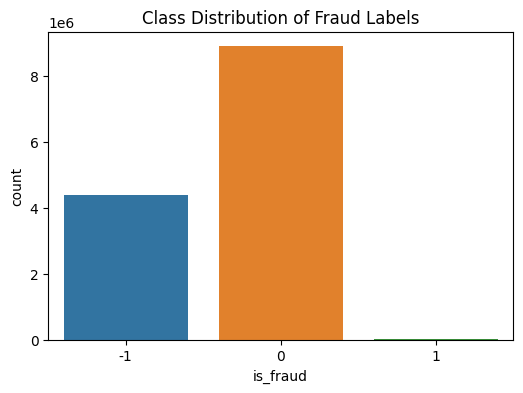

In [19]:
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=transactions_labeled_df)
plt.title('Class Distribution of Fraud Labels')
plt.show()

In [20]:
# Count of fraud vs. non-fraud
fraud_counts = transactions_labeled_df['is_fraud'].value_counts()
print('Fraud Label Counts:')
print(fraud_counts)

Fraud Label Counts:
is_fraud
 0    8901631
-1    4390952
 1      13332
Name: count, dtype: int64


## Supervised Fraud Detection
### Data Preparation

In [21]:
# Include only labeled data for supervised learning
supervised_df = transactions_labeled_df[transactions_labeled_df['is_fraud'] != -1]

# Define features and target variable
features = [
    'amount',
    'merchant_city',
    'merchant_state',
    'mcc_description',
    'transaction_hour',
    'transaction_dayofweek',
    'use_chip_Swipe Transaction',  # Adjust as per your one-hot encoded column
]

X = supervised_df[features]
y = supervised_df['is_fraud']

In [22]:
X.fillna(0, inplace=True)

In [23]:
# Standardize features for Logistic Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Model Training
Split data into training and testing sets:

In [24]:
# For Logistic Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# For Random Forest and XGBoost (no scaling needed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Train Logistic Regression model:

In [25]:
# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train_lr, y_train_lr)

LogisticRegression(max_iter=1000)

Train Random Forest model:

In [26]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Train XGBoost model:

In [27]:
# Initialize XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Model Evaluation
Evaluate Logistic Regression model:

In [28]:
# Predict on test data
y_pred_lr = lr_model.predict(X_test_lr)
y_proba_lr = lr_model.predict_proba(X_test_lr)[:, 1]

# Evaluate the model
print('Logistic Regression Classification Report:')
print(classification_report(y_test_lr, y_pred_lr))

print('Confusion Matrix:')
print(confusion_matrix(y_test_lr, y_pred_lr))

print('ROC AUC Score:', roc_auc_score(y_test_lr, y_proba_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.29      0.00      0.01      2666

    accuracy                           1.00   1782993
   macro avg       0.64      0.50      0.50   1782993
weighted avg       1.00      1.00      1.00   1782993

Confusion Matrix:
[[1780307      20]
 [   2658       8]]
ROC AUC Score: 0.8550054837675747


Evaluate Random Forest model:

In [29]:
# Predict on test data
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

print('ROC AUC Score:', roc_auc_score(y_test, y_proba_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.84      0.61      0.71      2666

    accuracy                           1.00   1782993
   macro avg       0.92      0.80      0.85   1782993
weighted avg       1.00      1.00      1.00   1782993

Confusion Matrix:
[[1780011     316]
 [   1042    1624]]
ROC AUC Score: 0.9197039287215647


Evaluate XGBoost model:

In [30]:
# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_xgb))

print('ROC AUC Score:', roc_auc_score(y_test, y_proba_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.95      0.66      0.78      2666

    accuracy                           1.00   1782993
   macro avg       0.97      0.83      0.89   1782993
weighted avg       1.00      1.00      1.00   1782993

Confusion Matrix:
[[1780228      99]
 [    904    1762]]
ROC AUC Score: 0.9902295180319612


Plot ROC curves:

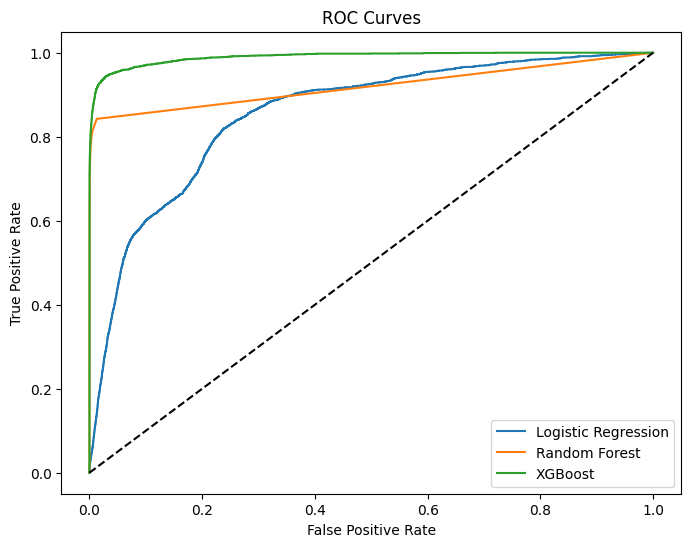

In [31]:
# Plot ROC curves
plt.figure(figsize=(8, 6))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Feature importance for Random Forest:

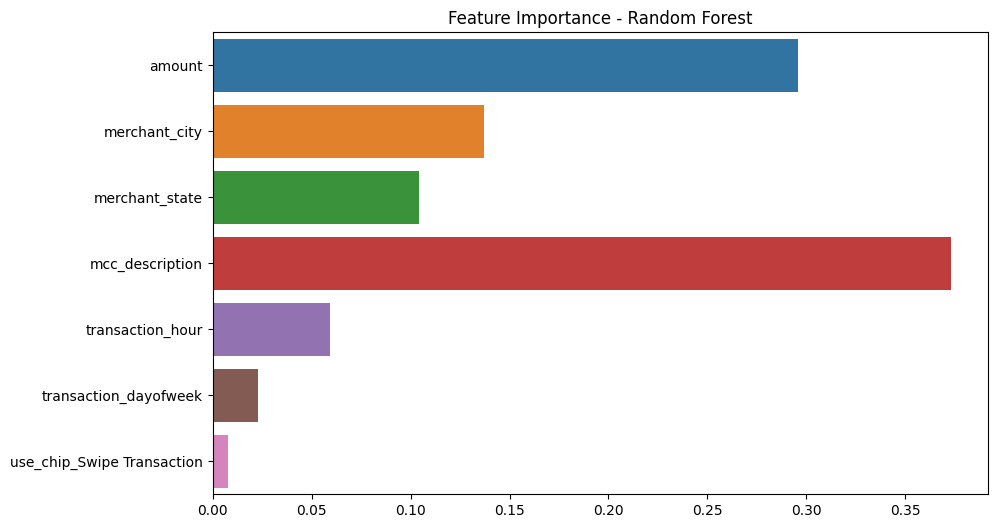

In [32]:
# Feature importances
rf_importances = rf_model.feature_importances_
rf_features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances, y=rf_features)
plt.title('Feature Importance - Random Forest')
plt.show()

Feature importance for XGBoost:

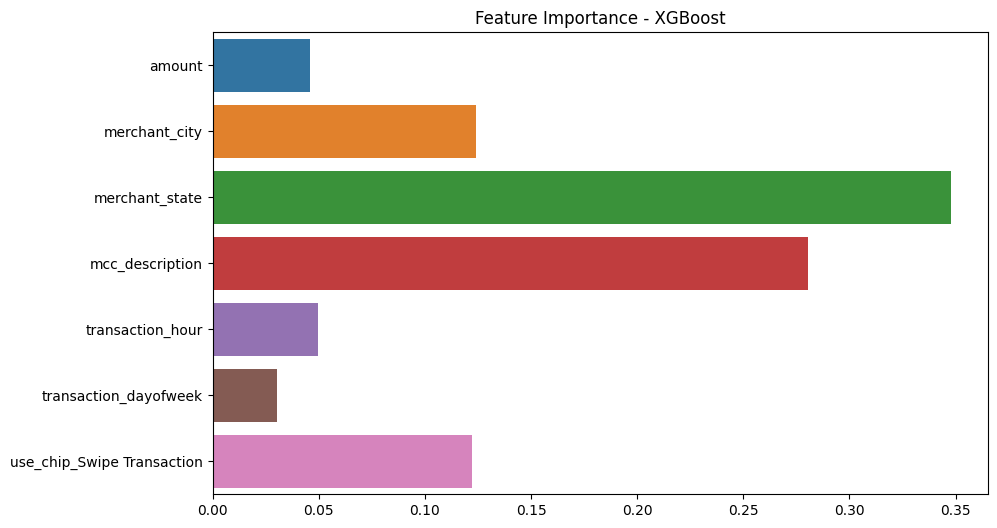

In [33]:
# Feature importances
xgb_importances = xgb_model.feature_importances_
xgb_features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances, y=xgb_features)
plt.title('Feature Importance - XGBoost')
plt.show()

## Unsupervised Anomaly Detection

 ### Isolation Forest
Prepare data for Isolation Forest:



In [34]:
# Features for unsupervised learning
features_unsup = [
    'amount',
    'merchant_city',
    'merchant_state',
    'mcc_description',
    'transaction_hour',
    'transaction_dayofweek',
    'use_chip_Swipe Transaction',
]

X_unsup = transactions_labeled_df[features_unsup]

# Ensure there are no missing values
X_unsup.fillna(0, inplace=True)

In [35]:
# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model
iso_forest.fit(X_unsup)

# Predict anomalies
anomalies = iso_forest.predict(X_unsup)  # -1 for anomalies, 1 for normal

In [36]:
# Add anomaly score to DataFrame
transactions_labeled_df['anomaly_score'] = anomalies

In [37]:
# Count of anomalies
anomaly_counts = transactions_labeled_df['anomaly_score'].value_counts()
print('Anomaly Counts:')
print(anomaly_counts)

Anomaly Counts:
anomaly_score
 1    13172855
-1      133060
Name: count, dtype: int64


Analyze anomalies:

In [38]:
# Filter anomalies
anomalies_df = transactions_labeled_df[transactions_labeled_df['anomaly_score'] == -1]

# Compare with known frauds
known_frauds = transactions_labeled_df[transactions_labeled_df['is_fraud'] == 1]

# Detected known frauds
detected_frauds = known_frauds[known_frauds['anomaly_score'] == -1]

print(f'Detected known frauds: {len(detected_frauds)} out of {len(known_frauds)}')

Detected known frauds: 267 out of 13332


Calculate detection rate:

In [39]:
detection_rate = len(detected_frauds) / len(known_frauds) * 100
print(f'Fraud Detection Rate: {detection_rate:.2f}%')

Fraud Detection Rate: 2.00%


## Merchant Category Analysis
### Identifying High-Risk Merchant Categories

#### Calculating Fraud Rate per MCC
Calculate the fraud rate for each Merchant Category Code (MCC) based on the labeled dataset.

In [40]:
# Fraud rate per MCC
mcc_fraud_rate = supervised_df.groupby('mcc_description')['is_fraud'].mean().reset_index()
mcc_fraud_rate.columns = ['mcc_description', 'fraud_rate']

# Sort by fraud rate in descending order
mcc_fraud_rate = mcc_fraud_rate.sort_values(by='fraud_rate', ascending=False)

# Display top MCCs by fraud rate
print('Top High-Risk MCCs by Fraud Rate:')
print(mcc_fraud_rate.head(10))

Top High-Risk MCCs by Fraud Rate:
    mcc_description  fraud_rate
24               24    0.597826
73               73    0.372549
63               63    0.118367
22               22    0.108338
40               40    0.103604
67               67    0.085938
35               35    0.085733
37               37    0.080586
82               82    0.068652
20               20    0.065385


 #### Identifying High-Risk Merchant Categories
Define high-risk MCCs based on the top MCCs with the highest fraud rates.

In [41]:
# Define high-risk MCCs (e.g., top 10)
top_n = 10  # You can adjust this number
high_risk_mccs = mcc_fraud_rate.head(top_n)['mcc_description'].tolist()

print('Identified High-Risk MCCs:')
for idx, mcc in enumerate(high_risk_mccs, start=1):
    print(f"{idx}. {mcc}")

Identified High-Risk MCCs:
1. 24
2. 73
3. 63
4. 22
5. 40
6. 67
7. 35
8. 37
9. 82
10. 20


#### Flagging High-Risk MCCs in Transactions
Create a new feature high_risk_mcc in the transactions DataFrame.

In [42]:
# Flag transactions with high-risk MCCs
transactions_labeled_df['high_risk_mcc'] = transactions_labeled_df['mcc_description'].apply(
    lambda x: 1 if x in high_risk_mccs else 0
)

# Check the count of high-risk transactions
print('Number of transactions with high-risk MCCs:', transactions_labeled_df['high_risk_mcc'].sum())

Number of transactions with high-risk MCCs: 17582


### Updating Features and Data
#### Updating the Feature Set
Add high_risk_mcc to the list of features used for modeling.

In [43]:
# Original features list (make sure it's defined)
# features = ['amount', 'merchant_city', 'merchant_state', 'mcc_description', 'transaction_hour', 
#             'transaction_dayofweek', 'use_chip_Swipe Transaction', 'high_risk_mcc']

# If 'features' is not yet defined, define it including 'high_risk_mcc'
# Note: Adjust 'use_chip_Swipe Transaction' to match your actual encoded column name

# Update features
features.append('high_risk_mcc')

# For supervised models, update X
supervised_df = transactions_labeled_df[transactions_labeled_df['is_fraud'] != -1]
X = supervised_df[features]
y = supervised_df['is_fraud']

Preparing Data for Retraining

In [44]:
# Ensure there are no missing values
X.fillna(0, inplace=True)

# If needed, re-encode any categorical variables (if the data has changed)
# For example, if you've added new data or the encoding might have been affected
# Re-encode 'merchant_city', 'merchant_state', 'mcc_description' if necessary

# Example re-encoding (if necessary)
# label_enc_cols = ['merchant_city', 'merchant_state', 'mcc_description']
# for col in label_enc_cols:
#     le = LabelEncoder()
#     X[col] = le.fit_transform(X[col].astype(str))

# For Logistic Regression, scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Retraining and Re-evaluating Models

In [45]:
# Split data into training and testing sets
# For Logistic Regression (using scaled features)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# For Random Forest and XGBoost (using unscaled features)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Logistic Regression

In [46]:
# Initialize Logistic Regression with the same parameters
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr_model.fit(X_train_lr, y_train_lr)

LogisticRegression(max_iter=1000, random_state=42)

In [47]:
# Predict on test data
y_pred_lr = lr_model.predict(X_test_lr)
y_proba_lr = lr_model.predict_proba(X_test_lr)[:, 1]

# Evaluate the model
print('Logistic Regression Classification Report (After Adding high_risk_mcc):')
print(classification_report(y_test_lr, y_pred_lr))

print('Confusion Matrix:')
print(confusion_matrix(y_test_lr, y_pred_lr))

print('ROC AUC Score:', roc_auc_score(y_test_lr, y_proba_lr))

Logistic Regression Classification Report (After Adding high_risk_mcc):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.36      0.01      0.01      2666

    accuracy                           1.00   1782993
   macro avg       0.68      0.50      0.51   1782993
weighted avg       1.00      1.00      1.00   1782993

Confusion Matrix:
[[1780293      34]
 [   2647      19]]
ROC AUC Score: 0.8612004194467017


#### Random Forest

In [48]:
# Initialize Random Forest with the same or optimized parameters
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
# Predict on test data
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print('Random Forest Classification Report (After Adding high_risk_mcc):')
print(classification_report(y_test, y_pred_rf))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

print('ROC AUC Score:', roc_auc_score(y_test, y_proba_rf))

Random Forest Classification Report (After Adding high_risk_mcc):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.84      0.61      0.71      2666

    accuracy                           1.00   1782993
   macro avg       0.92      0.81      0.85   1782993
weighted avg       1.00      1.00      1.00   1782993

Confusion Matrix:
[[1780010     317]
 [   1036    1630]]
ROC AUC Score: 0.9202319443670768


#### XGBoost


In [50]:
print("Features used for modeling:")
print(features)


Features used for modeling:
['amount', 'merchant_city', 'merchant_state', 'mcc_description', 'transaction_hour', 'transaction_dayofweek', 'use_chip_Swipe Transaction', 'high_risk_mcc']


In [51]:
from collections import Counter

feature_counts = Counter(features)
duplicates = [item for item, count in feature_counts.items() if count > 1]
print("Duplicate features:", duplicates)

Duplicate features: []


In [52]:
# Get column names
column_names = X.columns.tolist()

# Check for duplicates
column_counts = Counter(column_names)
duplicate_columns = [item for item, count in column_counts.items() if count > 1]
print("Duplicate columns in X:", duplicate_columns)

Duplicate columns in X: []


In [53]:
# Ensure you're not appending 'high_risk_mcc' multiple times
# For example:
features.append('high_risk_mcc')
# This line should only be executed once.

In [54]:
# Remove duplicates from features list
features = list(dict.fromkeys(features))  # This preserves the order

# Verify the features list
print("Features after removing duplicates:")
print(features)

Features after removing duplicates:
['amount', 'merchant_city', 'merchant_state', 'mcc_description', 'transaction_hour', 'transaction_dayofweek', 'use_chip_Swipe Transaction', 'high_risk_mcc']


In [55]:
# Recreate X with unique columns
X = supervised_df[features]

# Ensure that X has unique columns
X = X.loc[:, ~X.columns.duplicated()]

In [56]:
# Prepare the data
X = supervised_df[features]
y = supervised_df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [57]:

# Initialize XGBoost with the same or optimized parameters
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [58]:
# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print('XGBoost Classification Report (After Adding high_risk_mcc):')
print(classification_report(y_test, y_pred_xgb))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_xgb))

print('ROC AUC Score:', roc_auc_score(y_test, y_proba_xgb))

XGBoost Classification Report (After Adding high_risk_mcc):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.95      0.66      0.78      2666

    accuracy                           1.00   1782993
   macro avg       0.97      0.83      0.89   1782993
weighted avg       1.00      1.00      1.00   1782993

Confusion Matrix:
[[1780228      99]
 [    908    1758]]
ROC AUC Score: 0.9908486920070435


### Comparing Model Performances

#### ROC Curves

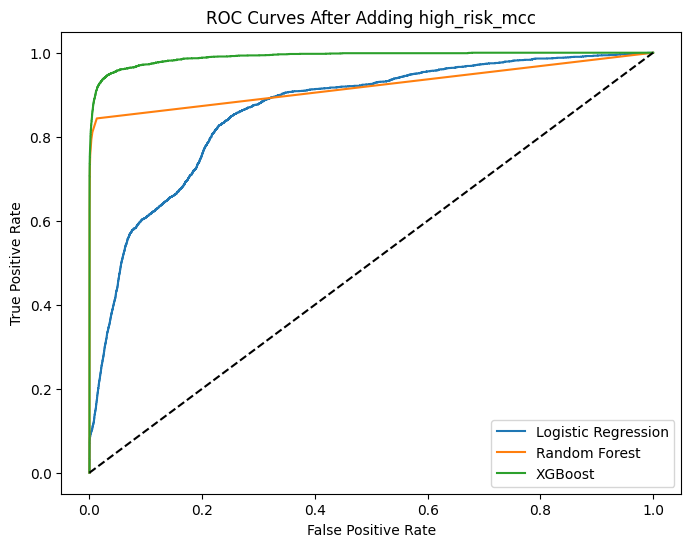

In [59]:
# Plot ROC curves
plt.figure(figsize=(8, 6))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC Curves After Adding high_risk_mcc')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Feature Importance

Random Forest Feature Importance:

In [60]:
print(f"Length of rf_importances: {len(rf_importances)}")
print(f"Length of rf_features: {len(rf_features)}")

Length of rf_importances: 7
Length of rf_features: 7


In [61]:
print(f"Type of rf_importances: {type(rf_importances)}")
print(f"Type of rf_features: {type(rf_features)}")

Type of rf_importances: <class 'numpy.ndarray'>
Type of rf_features: <class 'pandas.core.indexes.base.Index'>


In [62]:
# # Assuming 'X' is your feature DataFrame used to train the RandomForest

# print("Feature Names from rf_features:")
# print(rf_features)

# print("\nFeature Names from X.columns:")
# print(X.columns.tolist())

# print("\nChecking if rf_features matches X.columns:")
# print(rf_features == X.columns.tolist())

In [63]:
# duplicate_columns = X.columns[X.columns.duplicated()].tolist()
# print("Duplicate columns in X:", duplicate_columns)

In [64]:
# X = X.loc[:, ~X.columns.duplicated()]
# rf_features = X.columns.tolist()

In [65]:
# # Re-split the data if necessary
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # Retrain the Random Forest model
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Get the feature importances
# rf_importances = rf_model.feature_importances_

In [66]:
print(f"Length of rf_importances: {len(rf_importances)}")
print(f"Length of rf_features: {len(rf_features)}")

Length of rf_importances: 7
Length of rf_features: 7


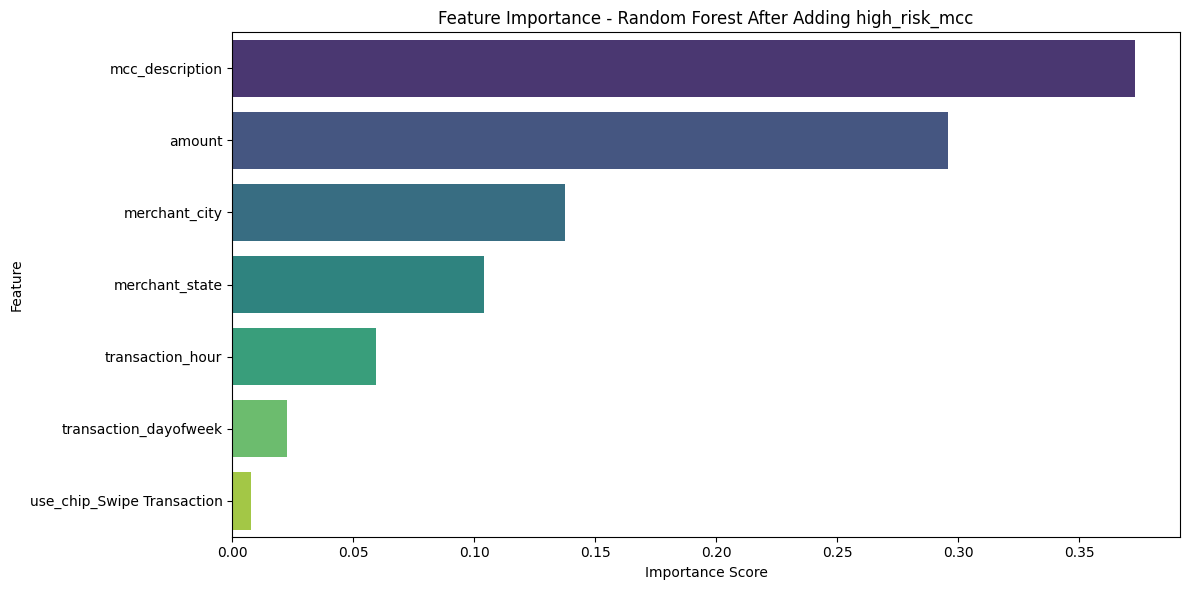

In [67]:
import pandas as pd

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': rf_features,
    'Importance': rf_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest After Adding high_risk_mcc')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

xgb Feature Importance:

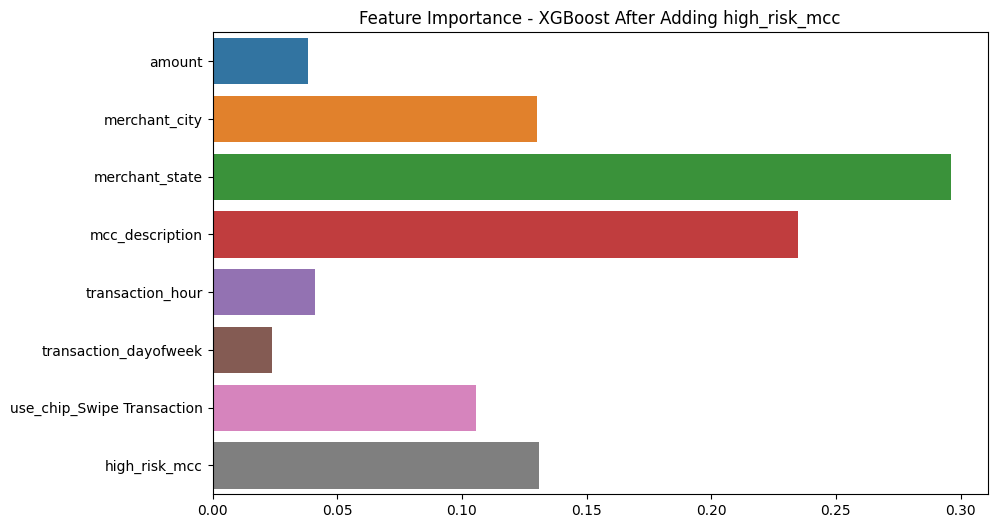

In [68]:
# Get feature importances
xgb_importances = xgb_model.feature_importances_
xgb_features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances, y=xgb_features)
plt.title('Feature Importance - XGBoost After Adding high_risk_mcc')
plt.show()

## Implementing Autoencoders for Anomaly Detection
Autoencoders can learn patterns of normal transactions and identify anomalies, which could be fraudulent.

###  Building the Autoencoder Model

In [69]:
non_fraud_df = transactions_labeled_df[transactions_labeled_df['is_fraud'] == 0]
X_auto = non_fraud_df[features].values

# Scale data
scaler_auto = StandardScaler()
X_auto_scaled = scaler_auto.fit_transform(X_auto)

In [70]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
# Define the autoencoder architecture
input_dim = X_auto_scaled.shape[1]
encoding_dim = 14  # Adjust based on your data

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(
    X_auto_scaled, X_auto_scaled,
    epochs=15,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 174s 1ms/step - loss: 0.4475 - val_loss: 0.4655
Epoch 2/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step - loss: 0.4119 - val_loss: 0.4657
Epoch 3/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 162s 1ms/step - loss: 0.4117 - val_loss: 0.4650
Epoch 4/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step - loss: 0.4116 - val_loss: 0.4651
Epoch 5/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 162s 1ms/step - loss: 0.4116 - val_loss: 0.4649
Epoch 6/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step - loss: 0.4113 - val_loss: 0.4649
Epoch 7/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 162s 1ms/step - loss: 0.4113 - val_loss: 0.4653
Epoch 8/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 164s 1ms/step - loss: 0.4114 - val_loss: 0.4649
Epoch 9/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 166s 1ms/step - loss: 0.4115 - val_loss: 0.4648
Epoch 10/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 165s 1ms/step - loss: 0.4112 - val_loss: 0.4656
Epoch 11/15
125180/125180 ━━━━━━━━━━━━━━━━━━━━ 164s 1ms/ste

###  Detecting Anomalies

In [71]:
# Prepare all data for testing
X_test_auto = transactions_labeled_df[features].values
X_test_auto_scaled = scaler_auto.transform(X_test_auto)

# Get reconstructed data
X_pred = autoencoder.predict(X_test_auto_scaled)

# Calculate reconstruction error
mse = np.mean(np.power(X_test_auto_scaled - X_pred, 2), axis=1)
transactions_labeled_df['reconstruction_error'] = mse

415810/415810 ━━━━━━━━━━━━━━━━━━━━ 431s 1ms/step


In [72]:
# Set threshold (e.g., 95th percentile of reconstruction errors from non-fraudulent transactions)
threshold = np.percentile(transactions_labeled_df[transactions_labeled_df['is_fraud'] == 0]['reconstruction_error'], 95)
print('Reconstruction error threshold:', threshold)

Reconstruction error threshold: 0.9006696306573677


In [73]:
transactions_labeled_df['anomaly_autoencoder'] = transactions_labeled_df['reconstruction_error'] > threshold
transactions_labeled_df['anomaly_autoencoder'] = transactions_labeled_df['anomaly_autoencoder'].astype(int)

In [74]:
# Confusion Matrix
cm = confusion_matrix(transactions_labeled_df['is_fraud'], transactions_labeled_df['anomaly_autoencoder'])
print('Confusion Matrix:')
print(cm)

# Classification Report
print('Classification Report:')
print(classification_report(transactions_labeled_df['is_fraud'], transactions_labeled_df['anomaly_autoencoder']))

Confusion Matrix:
[[      0 4171479  219473]
 [      0 8456549  445082]
 [      0   12557     775]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00   4390952
           0       0.67      0.95      0.79   8901631
           1       0.00      0.06      0.00     13332

    accuracy                           0.64  13305915
   macro avg       0.22      0.34      0.26  13305915
weighted avg       0.45      0.64      0.53  13305915



In [75]:
# First, let's check the lengths of our data
print("Length of supervised_df:", len(supervised_df))
print("Length of y_pred_rf:", len(y_pred_rf))
print("Length of y_proba_rf:", len(y_proba_rf))

# Ensure supervised_df and predictions are aligned
# Option 1: If supervised_df should match the length of predictions
supervised_df = supervised_df.iloc[:len(y_pred_rf)].copy()

Length of supervised_df: 8914963
Length of y_pred_rf: 1782993
Length of y_proba_rf: 1782993


In [76]:
# Option 2: If predictions should match supervised_df
# y_pred_rf = y_pred_rf[:len(supervised_df)]
# y_proba_rf = y_proba_rf[:len(supervised_df)]

# Reset index
supervised_df.reset_index(drop=True, inplace=True)

# Verify lengths are now equal
print("\nAfter alignment:")
print("Length of supervised_df:", len(supervised_df))
print("Length of y_pred_rf:", len(y_pred_rf))
print("Length of y_proba_rf:", len(y_proba_rf))


After alignment:
Length of supervised_df: 1782993
Length of y_pred_rf: 1782993
Length of y_proba_rf: 1782993


In [77]:
import pandas as pd
import numpy as np

# First, let's check the lengths of our data
print("Length of supervised_df:", len(supervised_df))
print("Length of y_pred_rf:", len(y_pred_rf))
print("Length of y_proba_rf:", len(y_proba_rf))

# Ensure supervised_df and predictions are aligned
# Option 1: If supervised_df should match the length of predictions
supervised_df = supervised_df.iloc[:len(y_pred_rf)].copy()

# Option 2: If predictions should match supervised_df
# y_pred_rf = y_pred_rf[:len(supervised_df)]
# y_proba_rf = y_proba_rf[:len(supervised_df)]

# Reset index
supervised_df.reset_index(drop=True, inplace=True)

# Verify lengths are now equal
print("\nAfter alignment:")
print("Length of supervised_df:", len(supervised_df))
print("Length of y_pred_rf:", len(y_pred_rf))
print("Length of y_proba_rf:", len(y_proba_rf))

# Create DataFrame of predictions
try:
    predictions_df = pd.DataFrame({
        'id': supervised_df['id'],
        'date': supervised_df['date'],
        'amount': supervised_df['amount'],
        'merchant_city': supervised_df['merchant_city'],
        'merchant_state': supervised_df['merchant_state'],
        'zip': supervised_df['zip'],
        'mcc_description': supervised_df['mcc_description'],
        'transaction_hour': supervised_df['transaction_hour'],
        'transaction_dayofweek': supervised_df['transaction_dayofweek'],
        'is_fraud_actual': supervised_df['is_fraud'],
        'is_fraud_pred_rf': y_pred_rf,
        'fraud_proba_rf': y_proba_rf,
    })

    # Map labels to categorical
    predictions_df['is_fraud_actual_label'] = predictions_df['is_fraud_actual'].map({1: 'Fraud', 0: 'Legitimate'})
    predictions_df['is_fraud_pred_rf_label'] = predictions_df['is_fraud_pred_rf'].map({1: 'Fraud', 0: 'Legitimate'})

    # Format date column
    predictions_df['date'] = pd.to_datetime(predictions_df['date']).dt.strftime('%Y-%m-%d %H:%M:%S')

    # Save to CSV
    predictions_df.to_csv('/kaggle/working/supervised_fraud_detection_data.csv', index=False)
    print("\nSupervised fraud detection data saved to 'supervised_fraud_detection_data.csv'")

except Exception as e:
    print("\nError creating DataFrame:", str(e))
    
    # Print shapes of all arrays for debugging
    print("\nShapes of arrays:")
    for column, data in [
        ('id', supervised_df['id']),
        ('date', supervised_df['date']),
        ('amount', supervised_df['amount']),
        ('merchant_city', supervised_df['merchant_city']),
        ('merchant_state', supervised_df['merchant_state']),
        ('zip', supervised_df['zip']),
        ('mcc_description', supervised_df['mcc_description']),
        ('transaction_hour', supervised_df['transaction_hour']),
        ('transaction_dayofweek', supervised_df['transaction_dayofweek']),
        ('is_fraud_actual', supervised_df['is_fraud']),
        ('is_fraud_pred_rf', y_pred_rf),
        ('fraud_proba_rf', y_proba_rf)
    ]:
        print(f"{column}: {len(data)}")

Length of supervised_df: 1782993
Length of y_pred_rf: 1782993
Length of y_proba_rf: 1782993

After alignment:
Length of supervised_df: 1782993
Length of y_pred_rf: 1782993
Length of y_proba_rf: 1782993

Supervised fraud detection data saved to 'supervised_fraud_detection_data.csv'


In [78]:
# Assuming transactions_labeled_df includes anomaly scores from Isolation Forest and Autoencoder

# Create a DataFrame for anomaly detection results
anomaly_detection_data = transactions_labeled_df[[
    'id', 'date', 'amount', 'merchant_city', 'merchant_state', 'zip', 'mcc_description',
    'transaction_hour', 'transaction_dayofweek', 'is_fraud', 'anomaly_score', 'anomaly_autoencoder'
]]

# Map labels for 'is_fraud'
anomaly_detection_data['is_fraud_label'] = anomaly_detection_data['is_fraud'].map({1: 'Fraud', 0: 'Legitimate', -1: 'Unknown'})

# Map anomaly scores to labels
anomaly_detection_data['anomaly_isolation_forest'] = anomaly_detection_data['anomaly_score'].map({1: 'Normal', -1: 'Anomaly'})
anomaly_detection_data['anomaly_autoencoder_label'] = anomaly_detection_data['anomaly_autoencoder'].map({1: 'Anomaly', 0: 'Normal'})

# Format date column
anomaly_detection_data['date'] = pd.to_datetime(anomaly_detection_data['date']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Drop unnecessary columns
anomaly_detection_data.drop(columns=['anomaly_score', 'anomaly_autoencoder'], inplace=True)

# Save to CSV
anomaly_detection_data.to_csv('/kaggle/working/unsupervised_anomaly_detection_data.csv', index=False)

print("Unsupervised anomaly detection data saved to 'unsupervised_anomaly_detection_data.csv'")

Unsupervised anomaly detection data saved to 'unsupervised_anomaly_detection_data.csv'


In [79]:
# Assuming high_risk_mccs is a list of high-risk MCC descriptions identified earlier

# Flag transactions with high-risk MCCs
transactions_labeled_df['high_risk_mcc'] = transactions_labeled_df['mcc_description'].apply(
    lambda x: 1 if x in high_risk_mccs else 0
)

# Prepare merchant category analysis data
merchant_category_data = transactions_labeled_df[[
    'id', 'date', 'amount', 'merchant_city', 'merchant_state', 'zip', 'mcc_description',
    'transaction_hour', 'transaction_dayofweek', 'is_fraud', 'high_risk_mcc'
]]

# Map labels
merchant_category_data['is_fraud_label'] = merchant_category_data['is_fraud'].map({1: 'Fraud', 0: 'Legitimate', -1: 'Unknown'})
merchant_category_data['high_risk_mcc_label'] = merchant_category_data['high_risk_mcc'].map({1: 'High Risk', 0: 'Normal'})

# Format date column
merchant_category_data['date'] = pd.to_datetime(merchant_category_data['date']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Save to CSV
merchant_category_data.to_csv('/kaggle/working/merchant_category_analysis_data.csv', index=False)

print("Merchant category analysis data saved to 'merchant_category_analysis_data.csv'")

Merchant category analysis data saved to 'merchant_category_analysis_data.csv'


In [80]:
# Assuming 'autoencoder' is your trained Keras model

# Option 1: Save in HDF5 format
autoencoder.save('/kaggle/working/autoencoder_model.keras')

print("Autoencoder model saved to 'autoencoder_model.keras'")

Autoencoder model saved to 'autoencoder_model.keras'
